Utility functions

In [6]:
import os
import pandas as pd
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create custom style dictionary
custom_style = {
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0
}

# Update seaborn's whitegrid style with your custom settings
sns.set_theme(style="whitegrid", rc=custom_style)
sns.set_context("paper", 
                font_scale=2.5,
                rc={
                    "lines.linewidth": 2,
                    "axes.grid": True,
                    "grid.alpha": 0.3,
                    "figure.figsize": (8.5, 6)
                })
from matplotlib import rc

rc('xtick.major', pad=10)
rc('ytick.major', pad=10)
rc('grid', linewidth=1.3)

def average_df_series(series):
    # Initialize an accumulator DataFrame for sums
    sum_df = None
    # Number of DataFrames in the series
    n = len(series)

    for df in series:
        # If sum_df is None, initialize it with the first DataFrame
        if sum_df is None:
            sum_df = df.copy()
        else:
            # Otherwise, add the current DataFrame to the sum_df
            sum_df += df

    # Divide each value by n to get the average
    average_df = sum_df / n
    return average_df


def get_runs(filters, proj="supercollapse", tune_on=None, avg_seeds=True, history=True):
    api = wandb.Api()
    runs = api.runs(proj, filters=filters, order="-created_at")
    summary_list, config_list, name_list = [], [], []
    history_list = []
    for run in runs:
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        if history:
            hist = run._sampled_history(keys=["compute", "test_loss", "lr", "tau"], x_axis="step", samples=100000)
            hist_df = pd.DataFrame(hist)
            hist_df['compute'] /= 1e15 # in units of peta flops
            hist_df = hist_df.ffill()
            # drop rows that have nans
            # hist_df = hist_df.dropna()
            history_list.append(hist_df)

    runs_dict = {
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
    }
    if history:
        runs_dict["history"] = history_list
    runs_df = pd.DataFrame(runs_dict)

    runs_df = runs_df[runs_df["summary"].apply(lambda x: x != {})]
    keys = [
        "num_params",
        "N",
        "V",
        "L",
        "alpha",
        "beta",
        "D",
        "B",
        "lr",
        "P",
        "schedule",
        "decay_frac",
        "test_loss",
        "seed"
    ]
    for key in keys:
        # For other keys, just extract the value if it exists
        runs_df[key] = runs_df["config"].apply(lambda x: x[key] if key in x else -1)

    # delete name summary and config
    runs_df = runs_df.drop(columns=["summary", "config", "name"])

    # Everything else being equal, only keep the best run
    if tune_on is not None:
        if "test_loss" in tune_on:
            idx = runs_df.groupby(keys)[tune_on].idxmin()
        else:
            idx = runs_df.groupby(keys)[tune_on].idxmax()
        runs_df = runs_df.loc[idx]
    # average over seeds
    if avg_seeds:
        keys = [k for k in keys if k != "seed"]
        numeric_cols = runs_df.select_dtypes(include=[np.number]).columns.tolist()
        agg_dict = {col: "mean" for col in numeric_cols}
        agg_dict.update({col: "first" for col in keys})
        if history:
            agg_dict["history"] = average_df_series
        history_cols = runs_df["history"].iloc[0].columns
        runs_df = runs_df.groupby(keys).agg(agg_dict).reset_index(drop=True)
        runs_df["history"] = runs_df["history"].apply(lambda row: pd.DataFrame(row, columns=history_cols))
    return runs_df


from scipy.interpolate import interp1d

def get_compute_frontier(df, C_min, C_max, D_min, D_max, n_points):
    C_max = min(C_max, max(row['history']['compute'].max() for _, row in df.iterrows()))
    C_eval = np.logspace(np.log10(C_min), np.log10(C_max), n_points)
    L_min = np.full_like(C_eval, np.inf)
    P_opt = np.full_like(C_eval, np.nan)
    D_opt = np.full_like(C_eval, np.nan)
    
    for _, row in df[(df['D'] >= D_min) & (df['D'] <= D_max)].iterrows():
        C, L = row['history']['compute'], row['history']['test_loss']
        interp = interp1d(np.log10(C), np.log10(L), bounds_error=False, fill_value=np.inf)
        L_new = 10**interp(np.log10(C_eval))
        mask = L_new < L_min
        L_min[mask] = L_new[mask]
        P_opt[mask] = row['P']
        D_opt[mask] = row['D']

    # remove nans    
    C_eval = C_eval[~np.isnan(P_opt)]
    L_min = L_min[~np.isnan(P_opt)]
    D_opt = D_opt[~np.isnan(P_opt)]
    P_opt = P_opt[~np.isnan(P_opt)]
    return C_eval, L_min, P_opt, D_opt

def fit_power_law(x, y):
    """
    Fit power law in the form y = (x/a)^b
    Returns a, b parameters and R²
    """
    # Take logs of both sides:
    # log(y) = b*log(x) - b*log(a)
    # log(y) = b*log(x) + c where c = -b*log(a)
    coeffs = np.polyfit(np.log10(x), np.log10(y), 1)
    b = coeffs[0]
    c = coeffs[1]
    # c = -b*log(a)
    # -c/b = log(a)
    # a = 10^(-c/b)
    a = 10**(-c/b)
    
    # Calculate R²
    y_pred = b * np.log10(x) + c
    r2 = np.corrcoef(np.log10(y), y_pred)[0,1]**2
    
    return a, b, r2
    

In [7]:
tag = "mlp_fit"
filters = {
    "config.wandb_tag": tag,
    "config.lr": 0.001,
    "config.schedule": 'const',
    "state": "finished",
}

df = get_runs(filters, proj="supercollapse", tune_on=None, history=True, avg_seeds=True)
df['P'] = df['num_params']
df = df.sort_values("P")

all_seeds_df = get_runs(filters, proj="supercollapse", tune_on=None, history=True, avg_seeds=False)
all_seeds_df['P'] = all_seeds_df['num_params']
all_seeds_df = all_seeds_df.sort_values("P")

cmap = sns.color_palette("plasma", as_cmap=True)
Pmin = df["P"].min()
Pmax = df["P"].max()
df['color'] = 0.9 * (np.log(df['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))

/home/shikai/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Copy these numbers to the experiment definition:
	Scale: 1346251.612836, Exponent: 2.040882


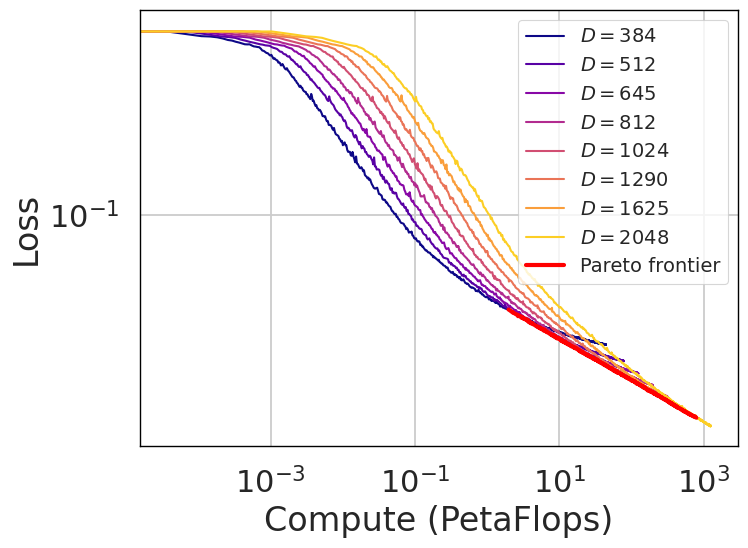

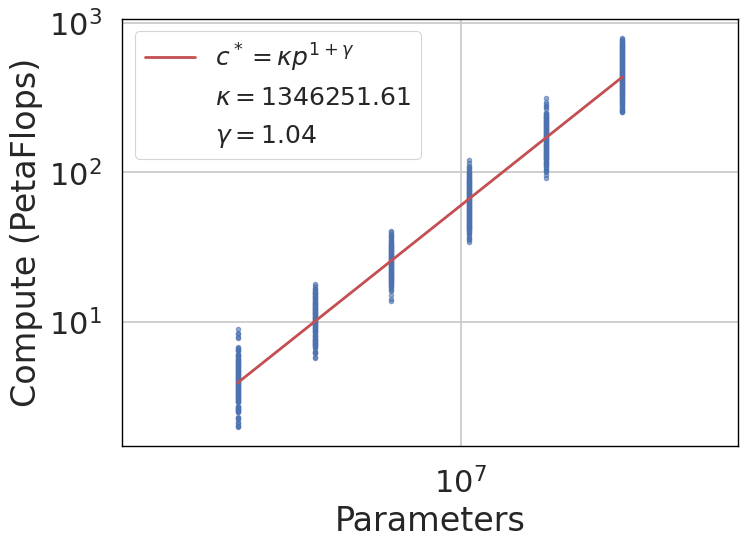

In [8]:
# For MLPs:
C_min, C_max = 1e-1, 1e4
D_min, D_max = 300, 10240

# For transformers:
# C_min, C_max = 10, 1e5
# D_min, D_max = 640, 2048

C_opt, L_opt, P_opt, D_opt = get_compute_frontier(df, C_min, C_max, D_min, D_max, 1000)
mask = (P_opt > P_opt.min()) & (P_opt < P_opt.max())
C_opt = C_opt[mask]
P_opt = P_opt[mask]
L_opt = L_opt[mask]
D_opt = D_opt[mask]


plt.figure(figsize=(8, 6), dpi=100)
for i, row in df.iterrows():
    plt.plot(row["history"]["compute"], row["history"]["test_loss"], color=cmap(row["color"]), lw=1.5, label=f"$D={row['D']}$")
plt.yscale("log")
plt.xscale("log")
# plt.ylim(3.13, 3.2)
plt.xlabel("Compute (PetaFlops)")
plt.ylabel("Loss")

plt.plot(C_opt, L_opt, color="red", lw=3, label="Pareto frontier")
plt.tight_layout()

plt.legend(fontsize=14, loc='upper right')

c, d, r2 = fit_power_law(P_opt, C_opt)
P_fit = np.linspace(P_opt.min(), P_opt.max(), 30)
C_fit = (P_fit / c) ** d

plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(P_opt, C_opt, s=10, alpha=0.6, color='b')
plt.plot(P_fit, C_fit, '-', label=r'$c^* = \kappa p^{1+\gamma}$', color='r')

plt.plot([], [], ' ', label=f'$\kappa = {c:.2f}$')
plt.plot([], [], ' ', label=f'$\gamma = {d-1:.2f}$')
plt.xlim(0.5 * P_opt.min(), P_opt.max() * 2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Parameters")
plt.ylabel("Compute (PetaFlops)")
plt.legend(fontsize=18)
plt.tight_layout()
print('Copy these numbers to the experiment definition:')
print(f'\tScale: {c:.6f}, Exponent: {d:.6f}')

Fitting Scaling Law

In [14]:
from scipy.optimize import minimize
from itertools import product

def fit_power_law_constant(C, L, num_inits=10, L0=None):
    """
    Fit power law with constant: L = a * C^(-b) + L0
    Uses Huber loss in log-log space for robustness
    
    Args:
        C: Compute values (array)
        L: Loss values (array) 
        num_inits: Number of initializations per parameter
    
    Returns:
        dict with fitted parameters and R^2 score
    """
    def power_law_const(params, x):
        if L0 is None:
            a, b, L0_fit = params
            return a * x**(-b) + L0_fit
        else:
            a, b = params
            return a * x**(-b) + L0
    
    def huber_loss(residual, delta=1e-3):
        mask = np.abs(residual) <= delta
        return np.where(mask, 
                       0.5 * residual**2,
                       delta * (np.abs(residual) - 0.5 * delta))
    
    def objective(params):
        pred = power_law_const(params, C)
        residuals = np.log(pred) - np.log(L)
        return np.mean(huber_loss(residuals))
    
    # Try all combinations of parameter initializations
    best_loss = np.inf
    best_params = None
    
    # Parameter ranges for initialization
    a_range = [0.1, 1]
    b_range = [0.01, 0.3]
    
    # Create evenly spaced initializations for each parameter
    a_inits = np.linspace(a_range[0], a_range[1], num_inits)
    b_inits = np.linspace(b_range[0], b_range[1], num_inits)
    
    if L0 is None:
        L0_range = [min(L)*0.1, min(L)]
        L0_inits = np.linspace(L0_range[0], L0_range[1], num_inits)
        # Try all combinations of a, b, and L0
        for a, b, L0_init in product(a_inits, b_inits, L0_inits):
            init_params = [a, b, L0_init]
            result = minimize(
                objective,
                init_params,
                method='L-BFGS-B',
                bounds=[(0, None), (0, None), (0, None)]  # Changed bounds to >= 0
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_params = result.x
    else:
        # Try all combinations of a and b
        for a, b in product(a_inits, b_inits):
            init_params = [a, b]
            result = minimize(
                objective,
                init_params,
                method='L-BFGS-B',
                bounds=[(0, None), (0, None)]  # Changed bounds to >= 0
            )
            
            if result.fun < best_loss:
                best_loss = result.fun
                best_params = result.x
            
    # Compute R^2 score
    y_pred = power_law_const(best_params, C)
    log_L = np.log(L)
    log_pred = np.log(y_pred)
    ss_res = np.sum((log_L - log_pred) ** 2)
    ss_tot = np.sum((log_L - np.mean(log_L)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    if L0 is None:
        return {
            'a': best_params[0],
            'b': best_params[1],
            'L0': best_params[2],
            'r2': r2
        }
    else:
        return {
            'a': best_params[0],
            'b': best_params[1],
            'L0': L0,
            'r2': r2
        }

def add_optimal_points(df):
    # Get interpolated loss at optimal compute
    def get_opt_loss(row):
        return row['history']['test_loss'].iloc[-1]
    
    df['opt_L'] = df.apply(get_opt_loss, axis=1)
    
    # For non-constant schedules, also update opt_C to be the last compute value
    def get_opt_compute(row):
        return row['history']['compute'].iloc[-1]
    
    df['opt_C'] = df.apply(get_opt_compute, axis=1)
    
    return df

def add_optimal_points_with_fit(df, a, b):
    # Calculate optimal compute from power law fit
    df['opt_C'] = (df['P'] / a) **b
    
    # Get interpolated loss at optimal compute
    df['opt_L'] = df.apply(lambda row: 
        10**interp1d(
            np.log10(row['history']['compute']), 
            np.log10(row['history']['test_loss']), 
            bounds_error=False, 
            fill_value=np.inf
        )(np.log10(row['opt_C'])), 
        axis=1)
    
    return df

def add_scaled_metrics(df, L0):
    for i, row in df.iterrows():
        history = row['history']
        opt_L = row['opt_L']
        opt_C = row['opt_C']
        
        history['scaled_L'] = (history['test_loss'] - L0) / (opt_L - L0)
        history['scaled_C'] = history['compute'] / opt_C
        
        df.at[i, 'history'] = history
    
    return df

/home/shikai/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1073824/4074936334.py:33: RuntimeWarning: divide by zero encountered in log
  residuals = np.log(pred) - np.log(L)
/home/shikai/.local/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


L = 0.05 · C^(-0.15) + 0.00e+00
R² = 1.0000


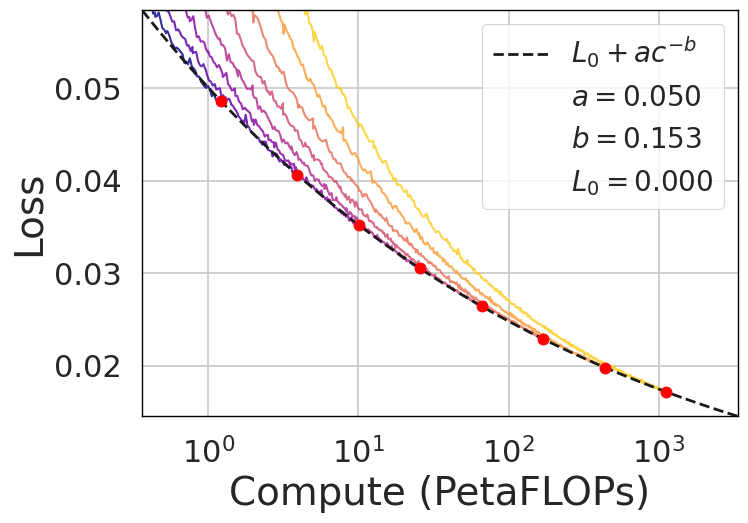

In [15]:
min_D = 384 # 768 for transformers
max_D = 2048
min_N = 3
max_N = 100
max_points = 1000
L0 = None 

df = add_optimal_points_with_fit(df, c, d)
all_seeds_df = add_optimal_points_with_fit(all_seeds_df, c, d)

plot_df = df[(df['D'] >= min_D) & (df['D'] <= max_D) & np.isfinite(df['opt_L']) & (df['N'] >= min_N) & (df['N'] <= max_N)]
plot_df_seeds = all_seeds_df[(all_seeds_df['D'] >= min_D) & (all_seeds_df['D'] <= max_D) & np.isfinite(all_seeds_df['opt_L']) & (all_seeds_df['N'] >= min_N) & (all_seeds_df['N'] <= max_N)]
Pmin = plot_df["P"].min()
Pmax = plot_df["P"].max()
plot_df['color'] = 0.9 * (np.log(plot_df['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))
plot_df_seeds['color'] = 0.9 * (np.log(plot_df_seeds['P']) - np.log(Pmin)) / (np.log(Pmax) - np.log(Pmin))

C = plot_df['opt_C'].values
L = plot_df['opt_L'].values

fit_results = fit_power_law_constant(C, L, L0=L0)

C_fit = np.logspace(np.log10(0.1 * C.min()), np.log10(10 * C.max()), 100)
def L_fit_fn(C):
    return fit_results['a'] * C**(-fit_results['b']) + fit_results['L0']
L_fit = L_fit_fn(C_fit)

print(f"L = {fit_results['a']:.2f} · C^(-{fit_results['b']:.2f}) + {fit_results['L0']:.2e}")
print(f"R² = {fit_results['r2']:.4f}")

plt.figure(figsize=(8, 5.75), dpi=100)
# legend a, b, L0
plt.plot(C_fit, L_fit, '--k', alpha=1, 
            label=r"$L_0 + ac^{{-b}}$", zorder=20)
plt.plot([], [], ' ', label=rf"$a = {fit_results['a']:.3f}$")
plt.plot([], [], ' ', label=rf"$b = {fit_results['b']:.3f}$")
plt.plot([], [], ' ', label=rf"$L_0 = {fit_results['L0']:.3f}$")

# Group seeds by P only
for P_value, seed_group in plot_df_seeds.groupby('P'):
    # Find corresponding mean run
    mean_row = plot_df[plot_df['P'] == P_value]
    
    if len(mean_row) == 0:
        continue
    
    mean_row = mean_row.iloc[0]
    mean_history = mean_row['history']
    
    # Collect all seed losses at each step
    seed_losses = []
    for _, seed_row in seed_group.iterrows():
        seed_losses.append(seed_row['history']['test_loss'].values)
    
    # Calculate mean and 90% CI
    loss_array = np.array(seed_losses)
    loss_mean = np.mean(loss_array, axis=0)
    
    # Calculate 90% confidence interval (5th and 95th percentiles)
    loss_lower = np.percentile(loss_array, 0, axis=0)
    loss_upper = np.percentile(loss_array, 100, axis=0)
    
    # Use compute steps from mean history
    compute_steps = mean_history['compute'].values
    mask = compute_steps <= mean_row['opt_C']
    
    # Plot mean line
    plt.plot(compute_steps[mask], loss_mean[mask], color=cmap(mean_row["color"]), lw=1.5, alpha=0.8)
    
    # Plot shaded 90% CI region
    plt.fill_between(compute_steps[mask], 
                     loss_lower[mask], 
                     loss_upper[mask], 
                     color=cmap(mean_row["color"]), 
                     alpha=0.2)

plt.scatter(C, L, color='red', s=60, zorder=30)
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("Compute (PetaFLOPs)", fontsize=28)
plt.ylabel("Loss", fontsize=28)
C_min = C.min() * 0.3
C_max = C.max() * 3
L_max = L_fit_fn(C_min)
L_min = L_fit_fn(C_max)
plt.xlim(C_min, C_max)
plt.ylim(L_min, L_max)

from matplotlib.ticker import MaxNLocator
ax = plt.gca()
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))

plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()

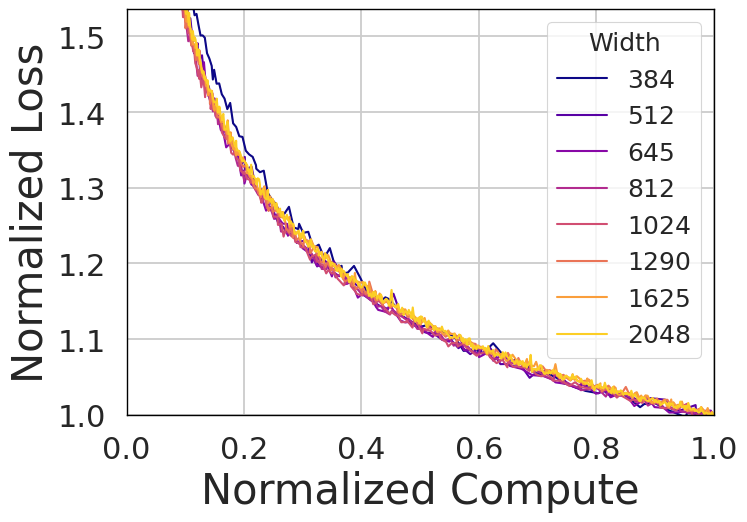

In [17]:
max_points = 1000
plt.figure(figsize=(8, 5.75), dpi=100)

L0 = fit_results['L0']
plot_df = add_scaled_metrics(plot_df, L0)
plot_df_seeds = add_scaled_metrics(plot_df_seeds, L0)

# Plot each mean run with 90% CI from seeds
for i, mean_row in plot_df.iterrows():
    # Find corresponding seeds
    seed_group = plot_df_seeds[plot_df_seeds['P'] == mean_row['P']]
    
    if len(seed_group) > 0:
        # Collect all seed scaled curves
        seed_scaled_C = []
        seed_scaled_L = []
        
        for _, seed_row in seed_group.iterrows():
            # Get seed's rescaled curve
            seed_steps = np.linspace(1, len(seed_row['history']['scaled_C']) - 1, max_points, dtype=int)
            seed_scaled_C.append(seed_row['history']['scaled_C'][seed_steps])
            seed_scaled_L.append(seed_row['history']['scaled_L'][seed_steps])
        
        # Compute mean and CI of scaled curves across seeds
        scaled_C_array = np.array(seed_scaled_C)
        scaled_L_array = np.array(seed_scaled_L)
        
        # Mean of scaled curves
        mean_scaled_C = np.mean(scaled_C_array, axis=0)
        mean_scaled_L = np.mean(scaled_L_array, axis=0)
        
        # 90% CI of scaled_L
        scaled_L_lower = np.percentile(scaled_L_array, 5, axis=0)
        scaled_L_upper = np.percentile(scaled_L_array, 95, axis=0)
        
        # Plot mean line
        plt.plot(mean_scaled_C, mean_scaled_L, color=cmap(mean_row['color']), 
                 lw=1.5, label=f"${mean_row['D']}$")
        
        # Plot shaded 90% CI region
        plt.fill_between(mean_scaled_C, 
                         scaled_L_lower, 
                         scaled_L_upper, 
                         color=cmap(mean_row['color']), 
                         alpha=0.2)
    else:
        # No seeds found, use the mean_row data as fallback
        steps = np.linspace(1, len(mean_row['history']['scaled_C']) - 1, max_points, dtype=int)
        mean_scaled_C = mean_row['history']['scaled_C'][steps]
        mean_scaled_L = mean_row['history']['scaled_L'][steps]
        
        plt.plot(mean_scaled_C, mean_scaled_L, color=cmap(mean_row['color']), 
                 lw=2, label=f"$D={mean_row['D']}$")

plt.xlabel("Normalized Compute", fontsize=30)
plt.ylabel("Normalized Loss", fontsize=30)
plt.xlim(0, 1)

# Find y_max using the largest D run
run = plot_df[plot_df['D'] == plot_df['D'].max()].iloc[0]
y_max = interp1d(run['history']['scaled_C'], run['history']['scaled_L'], bounds_error=False, fill_value=np.inf)(0.1)
plt.ylim(1, y_max)

# Remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(), by_label.keys(), fontsize=18, loc='upper right', title=r"Width")
legend.get_title().set_fontsize(18)

plt.tight_layout()